In [1]:
import numpy as np
from image_utils import *
import matplotlib.pyplot as plt
from Dummy_buildings_dataset_generator import SimpleSegmentationDataset
from torch.utils.data import DataLoader
import torch
from unet_meli import UNet
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.autograd import Variable
from random import randint
import os
import logging
import time
from IOU_computations import *
from torch import optim




## 1) Visualize dataset

Visualize one batch of the test set
Image 0
Input


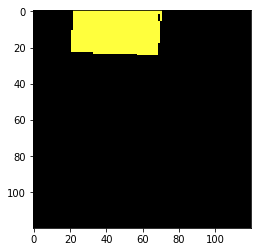

Groundtruth


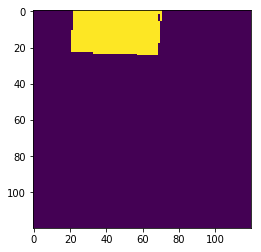

Distance Map


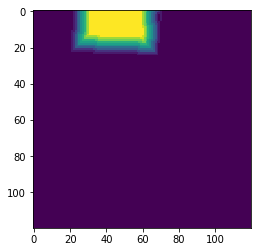

Image 1
Input


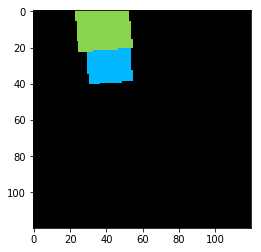

Groundtruth


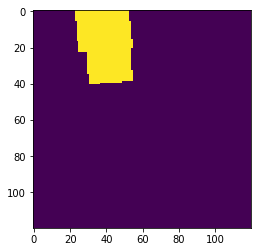

Distance Map


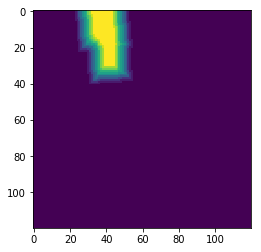

Image 2
Input


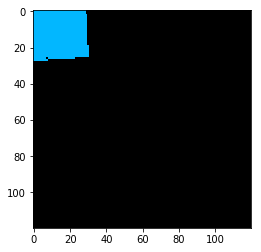

Groundtruth


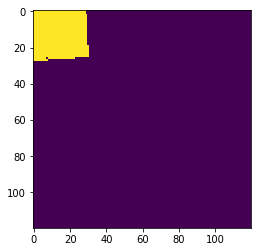

Distance Map


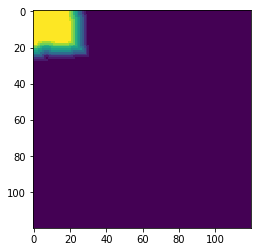

Image 3
Input


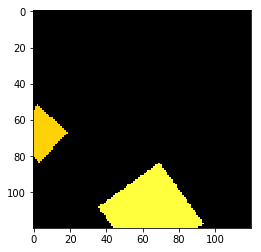

Groundtruth


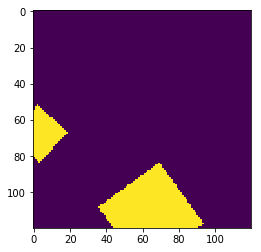

Distance Map


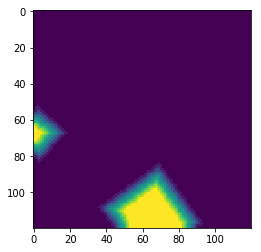

Image 4
Input


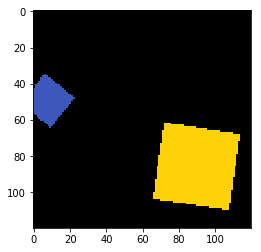

Groundtruth


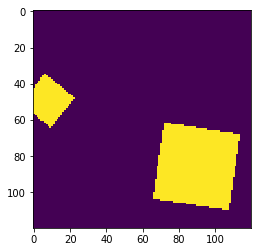

Distance Map


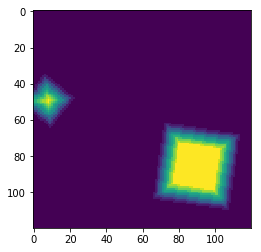

Image 5
Input


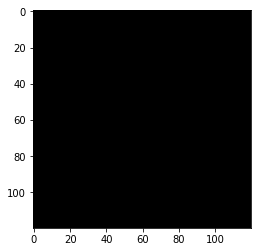

Groundtruth


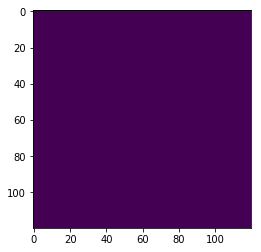

Distance Map


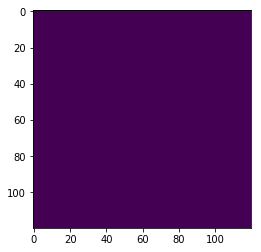

Image 6
Input


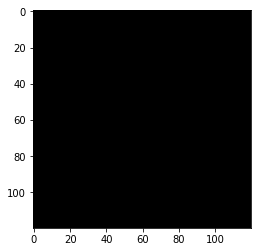

Groundtruth


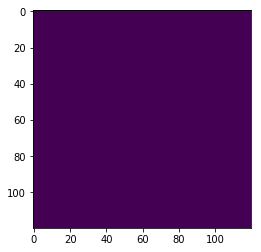

Distance Map


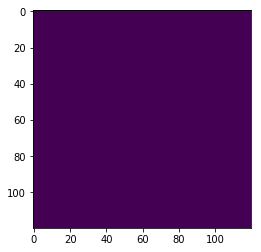

Image 7
Input


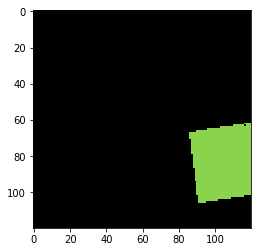

Groundtruth


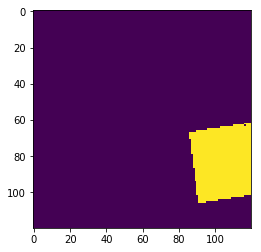

Distance Map


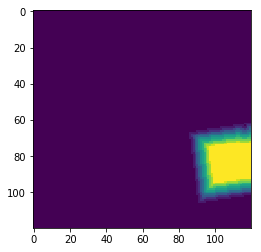

Image 8
Input


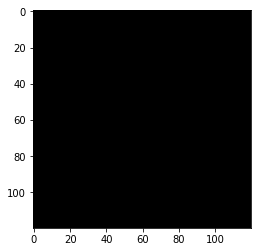

Groundtruth


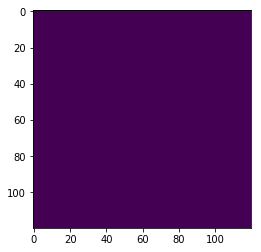

Distance Map


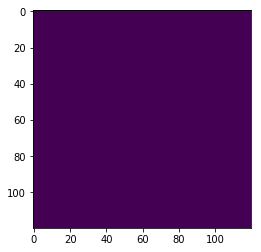

Image 9
Input


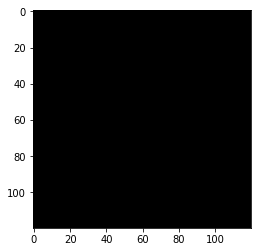

Groundtruth


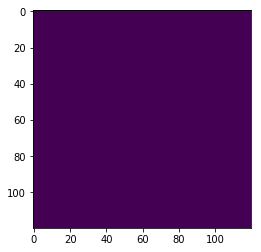

Distance Map


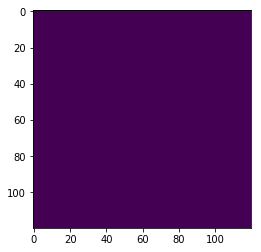

In [2]:
SIZE_PATCH=120
nb_objects_max_perimage=3
test_batch_size=10

test_generator=SimpleSegmentationDataset(SIZE_PATCH, nb_objects_max_perimage, alpha =1.0,virtual_size=100)
test_loader = DataLoader(test_generator, batch_size=test_batch_size,shuffle=True, num_workers=1)
sample_test=next(iter(test_loader))
X_test=sample_test['input']
Y_test=sample_test['groundtruth']
X_test=standardize(X_test)

%matplotlib inline
print('Visualize one batch of the test set')
for i in range(len(X_test)):
    print('Image %d'%i)
    print('Input')
    plt.imshow(np.asarray(X_test)[i])
    plt.show()
    print('Groundtruth')
    plt.imshow(np.argmax(np.asarray(Y_test)[i],axis=-1))
    plt.show()
    print('Distance Map')
    plt.imshow(np.argmax(np.asarray(distance_map_batch(Y_test))[i],axis=-1))
    plt.show()

## 3) Unet version

### Configuration

In [50]:
INPUT_CHANNELS=3
NB_CLASSES=2
DROPOUT=0.2
DEFAULT_BATCH_SIZE = 32
DEFAULT_EPOCHS =10
DEFAULT_VALID=50
DISPLAY_STEP=100
TRAINING_SIZE=4500
VALIDATION_SIZE=500
DISPLAY_STEP=100


DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
DEFAULT_FILTERS_SIZE=3
DEFAULT_FILTER_WIDTH=3
DEFAULT_LR=0.01
REDUCE_LR_STEPS = [1,5,8]


DISTANCE_NET=False
BINS=15
THRESHOLD=33

TEST_SAVE='MODEL_TEST/'

if not os.path.exists(TEST_SAVE):
            os.makedirs(TEST_SAVE)
        
TMP_IOU=TEST_SAVE+'TMP_IOU/'
if not os.path.exists(TMP_IOU):
            os.makedirs(TMP_IOU)
        


### Utils

In [51]:

logger=logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s %(message)s')
%matplotlib notebook

In [52]:
loss_fn=nn.CrossEntropyLoss()
def criterion(y,y_):

    y = y.contiguous().view(-1,y.size()[-1])
    y_ = y_.contiguous().view(-1,y.size()[-1])
    y = y.max(-1)[1]
    loss = loss_fn(y_,y)
    
    return loss


def predict(net,batch_x,dist_net=False):
    
    if dist_net:
        logits_dist,logits_seg=net(batch_x)
        return logits_dist.permute(0,2,3,1),logits_seg.permute(0,2,3,1)  
    else:
        logits=net(batch_x)
        return logits.permute(0,2,3,1)
    

def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """

    return 100.0 - (
        100.0 *
        np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
        (predictions.shape[0]*predictions.shape[1]*predictions.shape[2]))
def plot_summary(predictions,labels,prediction_dist,groundtruth_dist,pansharp,epoch):

    if prediction_dist is None and groundtruth_dist is None:
        fig,axs=plt.subplots(3, len(pansharp),figsize=(3*len(pansharp),9))

        labels=np.argmax(labels, 3) 
        logits=np.argmax(predictions, 3)

        for i in range(len(pansharp)):

            axs[0,i].imshow(pansharp[i])
            axs[1,i].imshow(labels[i]) 
            axs[2,i].imshow(logits[i])

    else:
        
        fig,axs=plt.subplots(5, len(pansharp),figsize=(5*len(pansharp),15))

        labels_seg=np.argmax(labels, 3) 
        logits_seg=np.argmax(predictions, 3)
        labels_dist=np.argmax(groundtruth_dist, 3) 
        logits_dist=np.argmax(prediction_dist, 3)

        for i in range(len(pansharp)):

            axs[0,i].imshow(pansharp[i])
            axs[1,i].imshow(labels_seg[i]) 
            axs[2,i].imshow(logits_seg[i])
            axs[3,i].imshow(labels_dist[i],cmap="jet")
            axs[4,i].imshow(logits_dist[i],cmap="jet")

    fig.canvas.draw()
    time.sleep(2)
    plt.close(fig)
    
def draw_update(loss,avg_loss_train,avg_loss_val,avg_iou, avg_f1,lr,fig,axs):
    if len(loss)==0 and len(lr)==0 and len(avg_loss_train)==0:

        axs[0].set_ylim(0,0.1)
        axs[0].set_title('Loss train')
        axs[1].set_ylim(0,0.001)
        axs[1].set_title('Avg losses')
        axs[2].set_ylim(0,DEFAULT_LR+DEFAULT_LR/10)
        axs[2].set_title('Learning rate')
        axs[3].set_title('Val IoU Avg')
        axs[4].set_title('Val F1 IoU')

    else:
 
        epoch=np.arange(len(avg_loss_train))
        ite=np.arange(len(loss))
        axs[0].plot(ite, loss, 'r-') 
        axs[1].plot(epoch, avg_loss_train, 'r-',epoch, avg_loss_val, 'g-')
        axs[2].plot(ite, lr, 'b-') 
        axs[3].plot(epoch, avg_iou, 'm-') 
        axs[4].plot(epoch, avg_f1, 'm-') 
        fig.canvas.draw()
        time.sleep(4)

### Initialization

2018-04-22 18:47:27,566 Initialization
/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


<IPython.core.display.Javascript object>


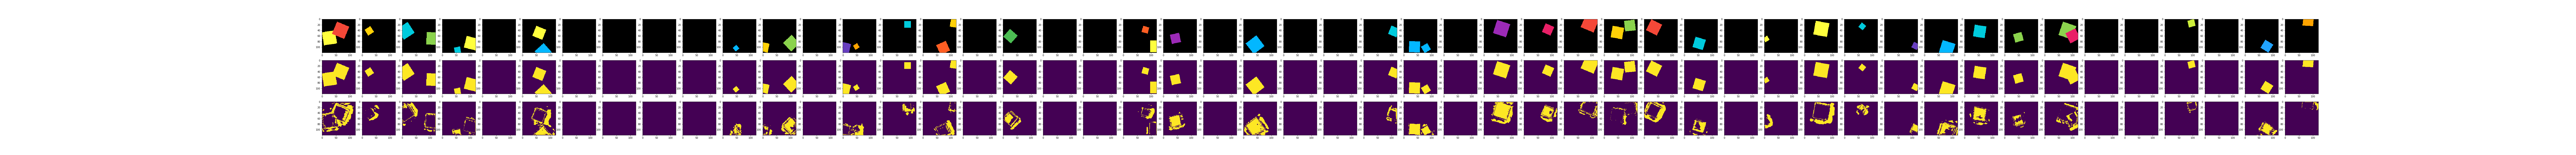

2018-04-22 18:47:43,676 Verification  loss= 0.6488,error= 8.6176%


In [53]:
val_generator=SimpleSegmentationDataset(SIZE_PATCH, nb_objects_max_perimage, alpha =1.0,virtual_size=VALIDATION_SIZE)
val_loader = DataLoader(val_generator, batch_size=DEFAULT_VALID,shuffle=False, num_workers=1)
RBD=randint(0,int(val_loader.__len__())-1)
train_generator=SimpleSegmentationDataset(SIZE_PATCH, nb_objects_max_perimage, alpha =1.0,virtual_size=TRAINING_SIZE)

net=UNet(INPUT_CHANNELS,NB_CLASSES,depth =DEFAULT_LAYERS,n_features_zero =DEFAULT_FEATURES_ROOT,width_kernel=DEFAULT_FILTER_WIDTH,dropout=DROPOUT,distance_net=DISTANCE_NET,bins=BINS)
net.cuda()
cudnn.benchmark = True



loss_train=[]
avg_loss_train=[]
avg_loss_val=[]
avg_iou=[]
avg_f1=[]
lr_train=[]


logging.info("Initialization")
loss_v=0
error_rate_v=0
for i_batch,sample in enumerate(val_loader):
    batch_x=standardize(sample['input'])
    batch_y=sample['groundtruth']

    X = Variable(batch_x.float())
    X=X.permute(0,3,1,2).cuda()  
    Y = Variable(batch_y.float())
    Y=Y.cuda()
    if DISTANCE_NET:
        y_dist=distance_map_batch(batch_y,THRESHOLD,BINS)
        Y_dist = Variable(y_dist.float())
        Y_dist=Y_dist.cuda()

        probs_dist,probs_seg=predict(net,X,DISTANCE_NET)

        loss_seg=criterion(Y,probs_seg)

        loss_dist=criterion(Y_dist,probs_dist)
        loss=loss_seg+loss_dist

        prediction_seg_v=probs_seg.data.cpu().numpy()
        groundtruth_seg_v=np.asarray(batch_y)
        prediction_dist_v=probs_dist.data.cpu().numpy()
        groundtruth_dist=np.asarray(y_dist)


    else:
        probs=predict(net,X)
        loss=criterion(Y,probs)

        prediction_seg_v=probs.data.cpu().numpy()
        groundtruth_seg_v=np.asarray(batch_y)
        prediction_dist_v=None
        groundtruth_dist=None


    loss_v+=loss.data[0]

    error_rate_v+=error_rate(prediction_seg_v,groundtruth_seg_v)

    if i_batch==RBD:
        pansharp=np.asarray(batch_x)
        plot_summary(prediction_seg_v,groundtruth_seg_v,prediction_dist_v,groundtruth_dist,pansharp,"__init__")



loss_v/=val_loader.__len__()   
error_rate_v/=val_loader.__len__()  
logging.info("Verification  loss= {:.4f},error= {:.4f}%".format(loss_v,error_rate_v))


### Optimization

<IPython.core.display.Javascript object>


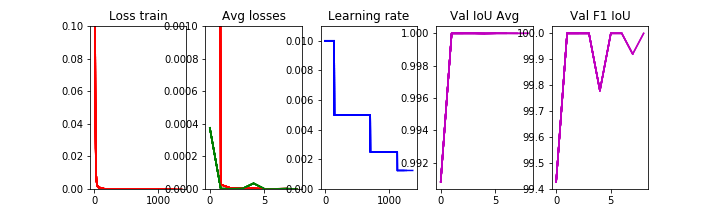

2018-04-22 18:47:44,613 Start optimization
/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")
2018-04-22 18:48:20,988  Training epoch_0, Minibatch Loss= 0.0295


<IPython.core.display.Javascript object>


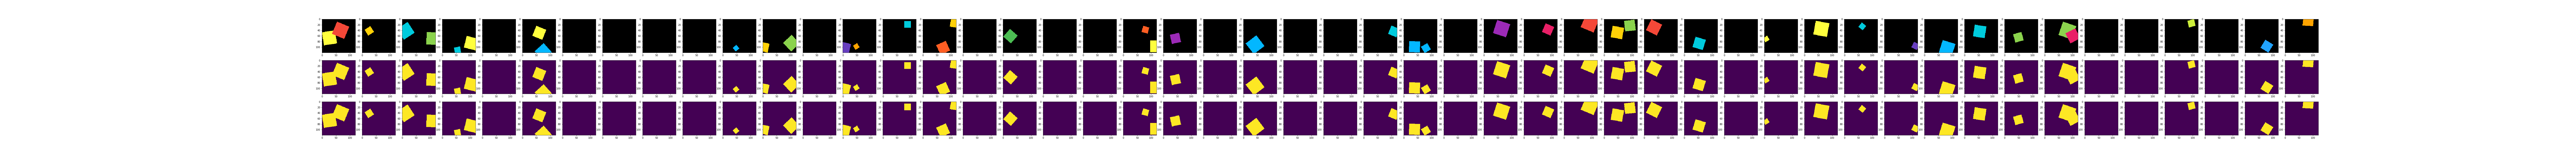

2018-04-22 18:49:53,054 Verification  loss= 0.0004,error rate= 0.0003,IOU = 0.9908, F1 IOU= 99.4281%
2018-04-22 18:50:30,333  Training epoch_1, Minibatch Loss= 0.0000


<IPython.core.display.Javascript object>


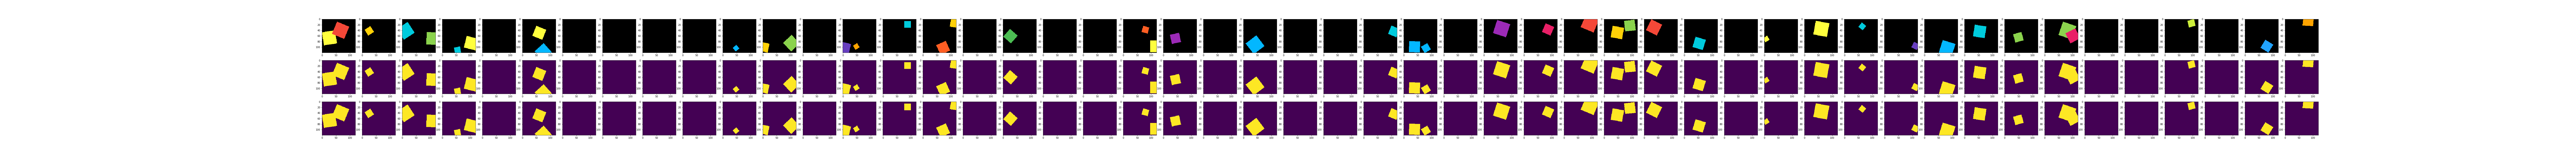

2018-04-22 18:52:01,390 Verification  loss= 0.0000,error rate= 0.0000,IOU = 1.0000, F1 IOU= 100.0000%
2018-04-22 18:52:39,482  Training epoch_2, Minibatch Loss= 0.0000


<IPython.core.display.Javascript object>


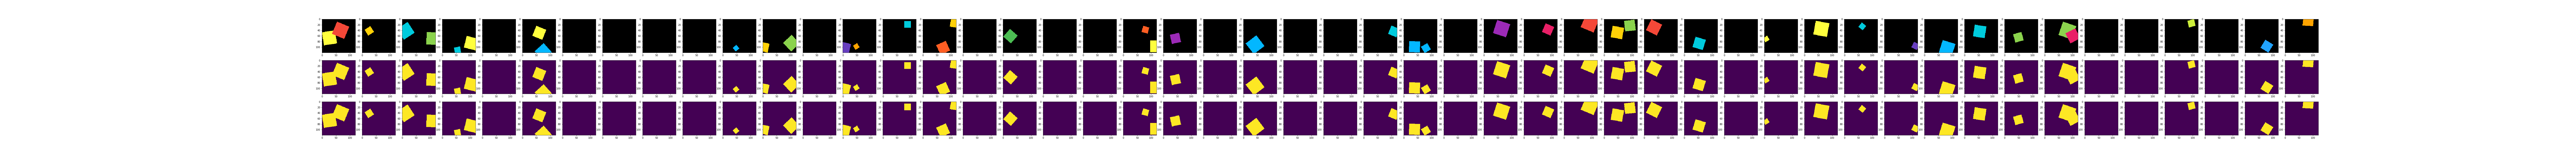

2018-04-22 18:54:14,920 Verification  loss= 0.0000,error rate= 0.0000,IOU = 1.0000, F1 IOU= 100.0000%
2018-04-22 18:54:52,274  Training epoch_3, Minibatch Loss= 0.0000


<IPython.core.display.Javascript object>


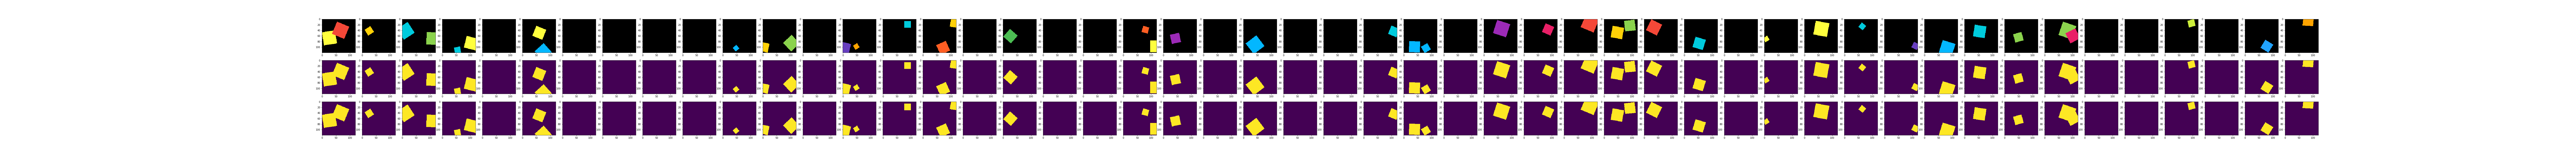

2018-04-22 18:56:20,564 Verification  loss= 0.0000,error rate= 0.0000,IOU = 1.0000, F1 IOU= 100.0000%
2018-04-22 18:56:57,410  Training epoch_4, Minibatch Loss= 0.0000


<IPython.core.display.Javascript object>


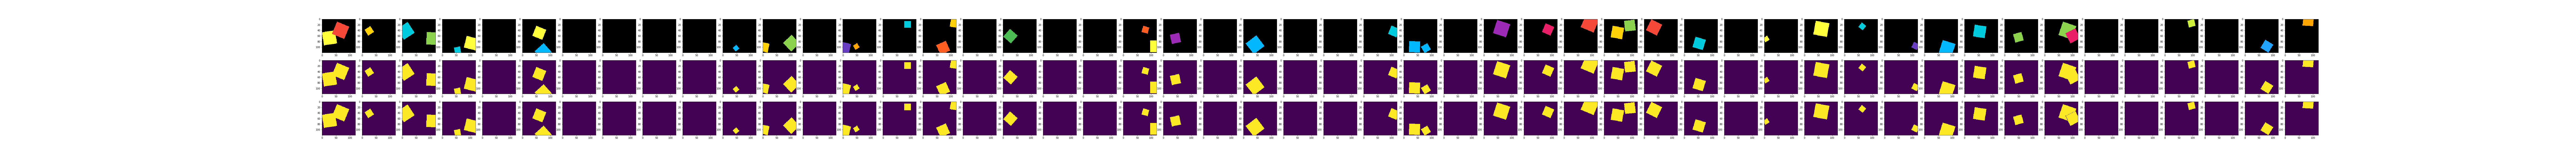

2018-04-22 18:58:25,659 Verification  loss= 0.0000,error rate= 0.0005,IOU = 1.0000, F1 IOU= 99.7788%
2018-04-22 18:59:01,725  Training epoch_5, Minibatch Loss= 0.0000


<IPython.core.display.Javascript object>


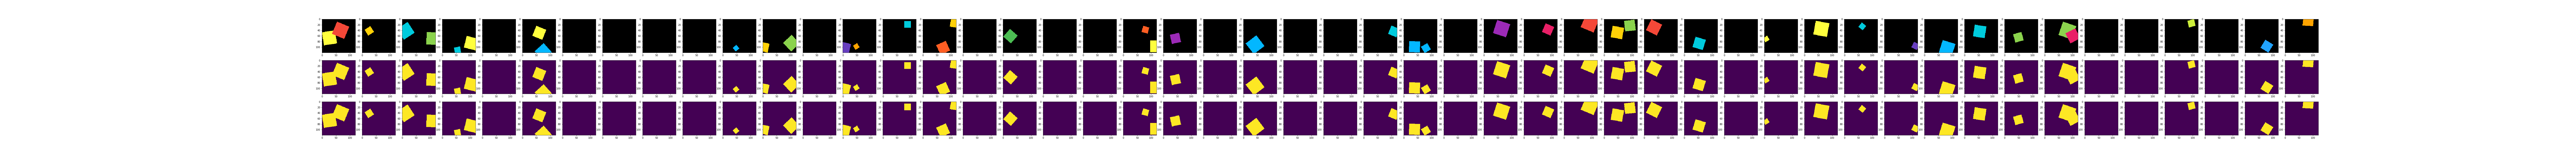

2018-04-22 19:00:37,652 Verification  loss= 0.0000,error rate= 0.0000,IOU = 1.0000, F1 IOU= 100.0000%
2018-04-22 19:01:14,297  Training epoch_6, Minibatch Loss= 0.0000


<IPython.core.display.Javascript object>


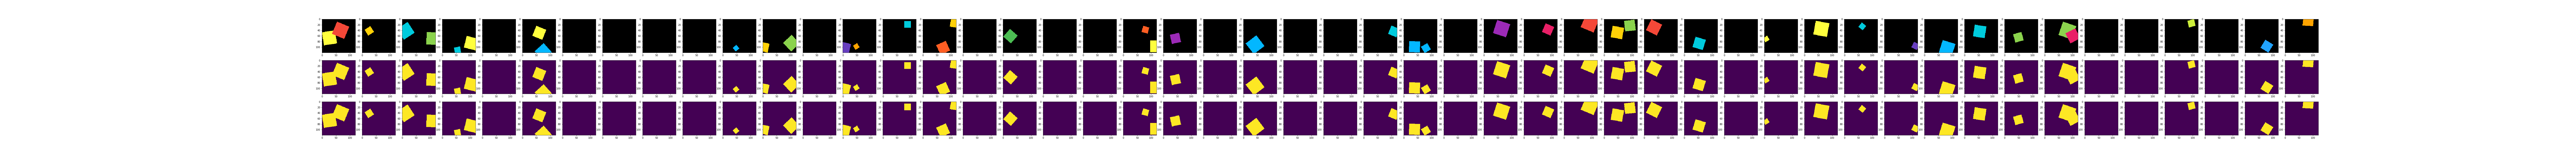

2018-04-22 19:02:46,823 Verification  loss= 0.0000,error rate= 0.0000,IOU = 1.0000, F1 IOU= 100.0000%
2018-04-22 19:03:24,162  Training epoch_7, Minibatch Loss= 0.0000


<IPython.core.display.Javascript object>


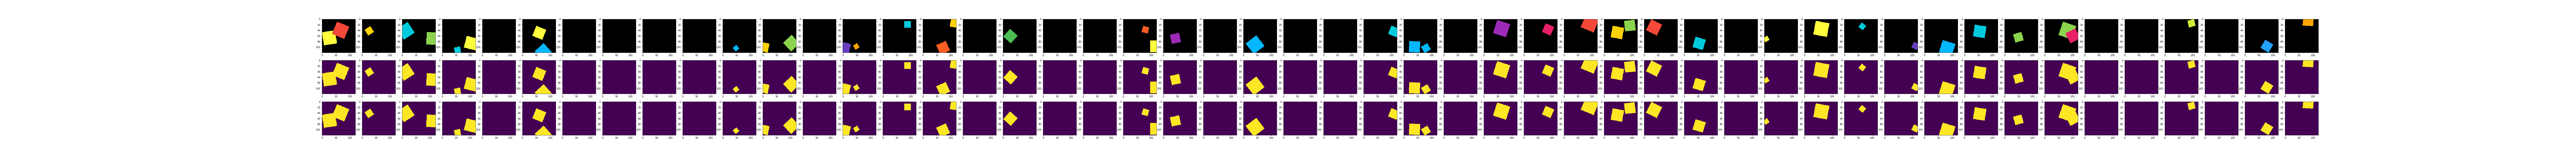

2018-04-22 19:04:56,947 Verification  loss= 0.0000,error rate= 0.0000,IOU = 1.0000, F1 IOU= 99.9200%
2018-04-22 19:05:34,213  Training epoch_8, Minibatch Loss= 0.0000


<IPython.core.display.Javascript object>


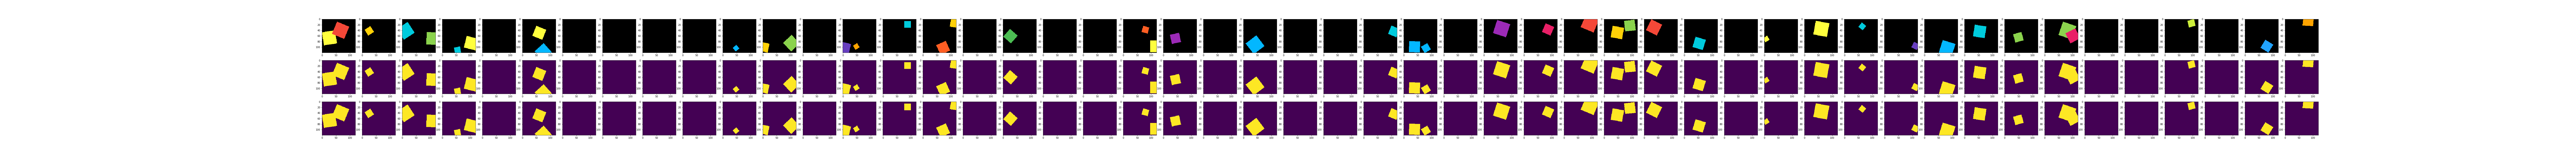

2018-04-22 19:07:11,820 Verification  loss= 0.0000,error rate= 0.0000,IOU = 1.0000, F1 IOU= 100.0000%
2018-04-22 19:07:49,372  Training epoch_9, Minibatch Loss= 0.0000


<IPython.core.display.Javascript object>


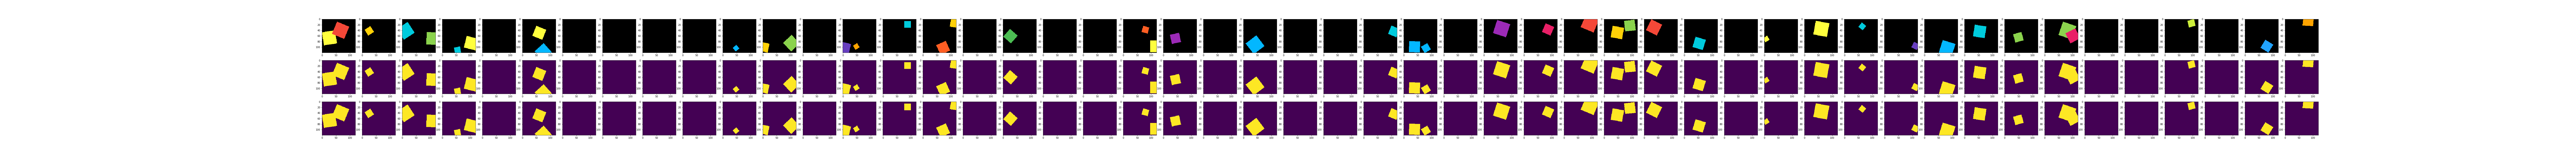

2018-04-22 19:09:24,171 Verification  loss= 0.0000,error rate= 0.0000,IOU = 1.0000, F1 IOU= 99.9600%


In [54]:
## Visualize live mode 
fig_follow,axs_follow =plt.subplots(1, 5,figsize=(10,3))
draw_update(loss_train,avg_loss_train,avg_loss_val,avg_iou,avg_f1,lr_train,fig_follow,axs_follow)

logging.info("Start optimization")

lr=DEFAULT_LR 
optimizer=optim.Adam(net.parameters(),lr=lr)

for epoch in range(DEFAULT_EPOCHS):
    ##tune learning reate
    if epoch in REDUCE_LR_STEPS:
        lr = lr * 0.5
        optimizer = torch.optim.Adam(net.parameters(), lr)
        
    total_loss = 0
    error_tot=0   
    train_loader = DataLoader(train_generator, batch_size=DEFAULT_BATCH_SIZE,shuffle=True, num_workers=1)
    counter=0
    for i_batch,sample_batch in enumerate(train_loader):
        
        batch_x=standardize(sample_batch['input'])
        batch_y=sample_batch['groundtruth']

        ##Variables input and output transformed for cuda
        X = Variable(batch_x.float())
        X=X.permute(0,3,1,2).cuda()  
        Y = Variable(batch_y.float())
        Y=Y.cuda()

        ## fwd
        if DISTANCE_NET:
            Y_dist=distance_map_batch(batch_y,THRESHOLD,BINS)
            Y_dist = Variable(Y_dist.float())
            Y_dist=Y_dist.cuda()

            probs_dist,probs_seg=predict(net,X,DISTANCE_NET)
            optimizer.zero_grad()
            loss_seg=criterion(Y,probs_seg)
            loss_dist=criterion(Y_dist,probs_dist)
            loss=loss_seg+loss_dist

        else:    
            probs=predict(net,X)
            optimizer.zero_grad()
            loss=criterion(Y,probs)
            Y_dist=None

        loss.backward()
        optimizer.step()

        total_loss+=loss.data[0]
        loss_train.append(loss.data[0])
        lr_train.append(lr)
        
        if counter % DISPLAY_STEP == 0:
            draw_update(loss_train,avg_loss_train,avg_loss_val,avg_iou,avg_f1,lr_train,fig_follow,axs_follow)
        counter+=1
        
    avg_loss_train.append(total_loss/train_loader.__len__())
    logging.info(" Training {:}, Minibatch Loss= {:.4f}".format("epoch_%s"%epoch,total_loss/train_loader.__len__()))
    loss_v=0
    iou_v=0
    f1_v=0
    error_rate_v=0
    name="epoch_%s"%epoch

    for i_batch,sample in enumerate(val_loader):
        batch_x=standardize(sample['input'])
        batch_y=sample['groundtruth']

        X = Variable(batch_x.float())
        X=X.permute(0,3,1,2).cuda()  
        Y = Variable(batch_y.float())
        Y=Y.cuda()
        if DISTANCE_NET:
            y_dist=distance_map_batch(batch_y,THRESHOLD,BINS)
            Y_dist = Variable(y_dist.float())
            Y_dist=Y_dist.cuda()
            probs_dist,probs_seg=predict(net,X,DISTANCE_NET)
            loss_seg=criterion(Y,probs_seg)
            loss_dist=criterion(Y_dist,probs_dist)
            loss=loss_seg+loss_dist
            prediction_seg_v=probs_seg.data.cpu().numpy()
            groundtruth_seg_v=np.asarray(batch_y)
            prediction_dist_v=probs_dist.data.cpu().numpy()
            groundtruth_dist=np.asarray(y_dist)

        else:
            probs=predict(net,X)
            loss=criterion(Y,probs)
            prediction_seg_v=probs.data.cpu().numpy()
            groundtruth_seg_v=np.asarray(batch_y)
            prediction_dist_v=None
            groundtruth_dist=None

        loss_v+=loss.data[0]
    
        __,f1,iou=predict_score_batch(TMP_IOU,np.argmax(groundtruth_seg_v,3),np.argmax(prediction_seg_v,3))
        
        iou_v+=iou
        f1_v+=f1
       
        error_rate_v+=error_rate(prediction_seg_v,groundtruth_seg_v)
        
        if i_batch==RBD:
            pansharp=np.asarray(batch_x)
            
            plot_summary(prediction_seg_v,groundtruth_seg_v,prediction_dist_v,groundtruth_dist,pansharp,name)
           

    loss_v/=val_loader.__len__()
    error_rate_v/=val_loader.__len__()
    avg_loss_val.append(loss_v)
    iou_v/=val_loader.__len__()  
    f1_v/=val_loader.__len__()  
    avg_iou.append(iou_v)
    avg_f1.append(f1_v)
    logging.info("Verification  loss= {:.4f},error rate= {:.4f},IOU = {:.4f}, F1 IOU= {:.4f}%".format(loss_v,error_rate_v,iou_v,f1_v)) 
        
        